In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import time
import os

# --- 1. CONFIGURACIÓN INICIAL PARA AMAZON ---
TERMINO_BUSQUEDA = "computadores"
URL_INICIAL = f"https://www.amazon.com/s?k={TERMINO_BUSQUEDA}" 
NUMERO_DE_PAGINAS = 5 # Extracción de 5 páginas

# Headers avanzados para simular un navegador genuino
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Referer': 'https://www.amazon.com/', 
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'es-ES,es;q=0.9',
    'Cookie': 'custom_cookie=true',
    'Connection': 'keep-alive',
}

# --- Función Auxiliar para Limpieza de Precios (FINAL Y ROBUSTA) ---
def limpiar_precio(precio_str):
    """Limpia el string de precio, elimina símbolos, comas, y garantiza formato float para el cálculo."""
    if isinstance(precio_str, str):
        # 1. Eliminar caracteres no deseados y texto de referencia
        precio_limpio = precio_str.replace('\u00a0', ' ').replace('USD', '').replace('PEN', '').replace('S/', '').replace('$', '').replace('PVPR:', '').replace('Lista:', '').strip()
        
        # 2. Manejar separadores: Eliminar comas (separadores de miles)
        precio_limpio = precio_limpio.replace(',', '') 
        
        # 3. Forzar formato de un solo punto decimal, eliminando puntos extras.
        if precio_limpio.count('.') > 1:
             partes = precio_limpio.rsplit('.', 1) 
             entero = partes[0].replace('.', '') 
             decimal = partes[1] if len(partes) > 1 else '00'
             precio_limpio = f"{entero}.{decimal}"
        
        # 4. Asegurar que no hay doble punto residual
        precio_limpio = precio_limpio.replace('..', '.')
        
        try:
            # 5. Intentar la conversión final a flotante
            return float(precio_limpio.strip())
        except ValueError:
            return None
    return None

# --- 2. FUNCIÓN DE SOLICITUD HTTP Y PARSEO ---
def obtener_contenido_pagina(url):
    """
    Realiza la solicitud HTTP GET y devuelve el objeto BeautifulSoup.
    """
    try:
        response = requests.get(url, headers=HEADERS, timeout=15)
        
        print(f"    - Código de estado HTTP recibido: {response.status_code}") 
        
        response.raise_for_status() 

        return BeautifulSoup(response.content, "html.parser")

    except requests.exceptions.RequestException as e:
        print(f"❌ Error al realizar la solicitud a {url}: {e}")
        return None

# --- 3. FUNCIÓN DE EXTRACCIÓN Y FILTRADO ESTRICTO ---
def extraer_datos_amazon_ofertas(soup):
    datos_productos = []
    # Selector principal
    contenedores_productos = soup.find_all('div', {'data-component-type': 's-search-result'})
    
    print(f"    -> Productos encontrados para extraer: {len(contenedores_productos)}")

    for contenedor in contenedores_productos:
        
        nombre = 'N/A'
        precio_antes = 'N/A'
        precio_despues = 'N/A'
        url_image = 'N/A'
        
        # --- Nombre del Producto ---
        titulo_h2 = contenedor.find('h2')
        if titulo_h2:
             span_titulo = titulo_h2.find('span')
             nombre = span_titulo.text.strip() if span_titulo else titulo_h2.text.strip()
        
        # --- Precio Actual (precio_despues) ---
        precio_span = contenedor.find('span', class_='a-price')
        if precio_span:
            p_entero = precio_span.find('span', class_='a-price-whole')
            p_fraccion = precio_span.find('span', class_='a-price-fraction')
            moneda = precio_span.find('span', class_='a-price-symbol')
            
            p_entero_str = p_entero.text.strip() if p_entero else ''
            p_fraccion_str = p_fraccion.text.strip() if p_fraccion else ''
            moneda_str = moneda.text.strip() if moneda else 'USD'
            
            if p_entero_str or p_fraccion_str:
                # Formato de salida del string, limpio de NBSP y dobles puntos
                precio_despues = f"{moneda_str} {p_entero_str}.{p_fraccion_str}".replace('\xa0', ' ').replace('..', '.') 

        # --- Precio Antes (precio_antes) ---
        precio_antes_tag = contenedor.find('span', class_='a-price', attrs={'data-a-strike': 'true'})
        
        if precio_antes_tag:
            offscreen_price = precio_antes_tag.find('span', class_='a-offscreen')
            if offscreen_price:
                precio_antes = offscreen_price.text.strip().replace('\u00a0', ' ')
            else:
                precio_antes = precio_antes_tag.text.strip().replace('\u00a0', ' ')
            
            # Limpieza de precio_antes para el string de salida
            precio_antes = precio_antes.replace('PVPR:', '').replace('Lista:', '').strip().replace('..', '.')
        
        # --- URL de la Imagen ---
        imagen_tag = contenedor.find('img', class_='s-image')
        url_image = imagen_tag.get('src') if imagen_tag and imagen_tag.get('src') else 'N/A'
        
        # --- Cálculo de Descuento ---
        descuento = '0%'
        
        # USAMOS LAS VERSIONES NUMÉRICAS LIMPIAS PARA EL CÁLCULO
        num_despues = limpiar_precio(precio_despues)
        num_antes = limpiar_precio(precio_antes) 
        
        if num_antes and num_despues and num_antes > num_despues:
            calc_descuento = ((num_antes - num_despues) / num_antes) * 100
            descuento = f"{calc_descuento:.0f}%" 
        
        # --- FILTRO ESTRICTO (FINAL) ---
        # Solo añadir si tiene NOMBRE, PRECIO ACTUAL, Y PRECIO ANTES (Oferta real)
        if nombre != 'N/A' and precio_despues != 'N/A' and precio_antes != 'N/A':
            datos_productos.append({
                "nombre": nombre.replace('\u00a0', ' '),
                "precio_antes": precio_antes.replace('\u00a0', ' '),
                "precio_despues": precio_despues.replace('\u00a0', ' '), 
                "descuento": descuento,
                "url_image": url_image
            })
        
    return datos_productos

# --- 4. ORQUESTACIÓN Y PAGINACIÓN DINÁMICA ---
def ejecutar_scraper_amazon_ofertas(url_inicial, num_paginas):
    """
    Función principal que maneja la paginación dinámica.
    """
    total_datos = []
    url_actual = url_inicial
    
    for pagina_actual in range(1, num_paginas + 1):
        if url_actual is None:
            print("⚠️ No se encontró el enlace a la página siguiente. Finalizando.")
            break
            
        print(f"\n📢 Procesando página {pagina_actual}/{num_paginas}. URL actual: {url_actual}")
        
        soup = obtener_contenido_pagina(url_actual)
        
        if soup is None:
            print("🛑 Error al obtener la página. Deteniendo el scraper.")
            break
            
        nuevos_datos = extraer_datos_amazon_ofertas(soup) 
        
        if not nuevos_datos and pagina_actual == 1:
             print("⚠️ ¡FALLO CRÍTICO! No se encontraron productos con oferta en la página 1.")
             break
        
        total_datos.extend(nuevos_datos)
        
        enlace_siguiente = soup.find('a', class_='s-pagination-next')

        if enlace_siguiente:
            url_actual = "https://www.amazon.com" + enlace_siguiente.get('href')
        else:
            url_actual = None 

        time.sleep(3) 

    return total_datos

# --- 5. EJECUCIÓN E IMPRESIÓN COMO LISTA DE DICCIONARIOS ---
if __name__ == "__main__":
    
    # Ejecutar el proceso de extracción
    resultados_finales_diccionario = ejecutar_scraper_amazon_ofertas(URL_INICIAL, NUMERO_DE_PAGINAS)
    
    if resultados_finales_diccionario:
        print(f"\n✅ Extracción de Amazon completada. Total de productos filtrados: {len(resultados_finales_diccionario)}.")
        
        # IMPRIMIR LA LISTA DE DICCIONARIOS (Formato profesional)
        print("\n--- SALIDA FINAL: LISTA DE DICCIONARIOS (Muestra de Ofertas Reales) ---")
        
        if len(resultados_finales_diccionario) > 0:
            # Imprimir una muestra para no saturar la salida
            print(json.dumps(resultados_finales_diccionario[:5], indent=4))
            print(f"\n... Se omiten {len(resultados_finales_diccionario) - 5} productos más para la vista previa. Total: {len(resultados_finales_diccionario)}.")
        
        # PARA EL TRABAJO COLABORATIVO: GUARDAR EN CSV
        df = pd.DataFrame(resultados_finales_diccionario)
        if not os.path.exists('data'): os.makedirs('data')
        df.to_csv('data/amazon_ofertas_filtradas.csv', index=False, encoding='utf-8')
        print("\n💾 Datos guardados en CSV: data/amazon_ofertas_filtradas.csv")
        
    else:
        print("\n⚠️ La extracción de Amazon no produjo resultados con los filtros aplicados.")


📢 Procesando página 1/5. URL actual: https://www.amazon.com/s?k=computadores
    - Código de estado HTTP recibido: 200
    -> Productos encontrados para extraer: 20

📢 Procesando página 2/5. URL actual: https://www.amazon.com/-/es/s?k=computadores&page=2&xpid=j4t0JyPjOtaXD&qid=1766787108&ref=sr_pg_1
    - Código de estado HTTP recibido: 200
    -> Productos encontrados para extraer: 20

📢 Procesando página 3/5. URL actual: https://www.amazon.com/-/es/s?k=computadores&page=3&language=es&qid=1766787113&xpid=j4t0JyPjOtaXD&ref=sr_pg_2
    - Código de estado HTTP recibido: 200
    -> Productos encontrados para extraer: 20

📢 Procesando página 4/5. URL actual: https://www.amazon.com/-/es/s?k=computadores&page=4&language=es&qid=1766787118&xpid=j4t0JyPjOtaXD&ref=sr_pg_3
    - Código de estado HTTP recibido: 200
    -> Productos encontrados para extraer: 20

📢 Procesando página 5/5. URL actual: https://www.amazon.com/-/es/s?k=computadores&page=5&language=es&qid=1766787123&xpid=j4t0JyPjOtaXD&re

In [ ]:
## Parte de Werlen
import pandas as pd
import requests

#-----------------------------------------
# 1. Obtener el tipo de cambio USD --> PEN 
#-----------------------------------------
def obtener_tasa_cambio():
    url = "https://api.exchangerate-api.com/v4/latest/USD"
    data = requests.get(url).json()
    return data["rates"]["PEN"]

tasa = obtener_tasa_cambio()
print("Tipo de cambio USD → PEN:", tasa)

#----------------------------------------
# 2. Función para convertir precios a PEN
#----------------------------------------
def convertir_a_pen(precio, tasa):
    if isinstance(precio, str):
        precio = precio.replace("PEN","").replace("$","").replace("S/.","").replace(",","").strip()
        return float(precio) * tasa if "$" in precio else float(precio)
    return None

#----------------------------------------
# 3. Variación de precios (antes vs después)
#----------------------------------------
def comparar(a, d):
    if a > d: return "Bajó"
    if a < d: return "Subió"
    return "Igual"

#----------------------------------------
# 4. Cargar Data de Amazon (Nicholas)
#----------------------------------------
df_amazon = pd.read_csv('data/amazon_ofertas_filtradas.csv')

# LIMPIAR Y CONVERTIR PRECIOS A NÚMEROS
df_amazon["precio_antes"] = df_amazon["precio_antes"].str.replace("PEN","").str.replace(",","").str.strip().astype(float)
df_amazon["precio_despues"] = df_amazon["precio_despues"].str.replace("PEN","").str.replace(",","").str.strip().astype(float)

# APLICAR VARIACIÓN
df_amazon["variacion"] = df_amazon.apply(
    lambda x: comparar(x["precio_antes"], x["precio_despues"]), axis=1
)

# MARCAR ORIGEN
df_amazon["tienda"] = "Amazon"

print(df_amazon.head())


Tipo de cambio USD → PEN: 3.37
                                                                                                                                                                                                        nombre  \
0       HP Computadora portátil 14, Intel Celeron N4020, 4 GB de RAM, 64 GB de almacenamiento, pantalla HD de microborde de 14 pulgadas, Windows 11 Home, delgada y portátil, gráficos 4K, un año de Microsoft   
1  HP ProDesk 600 G3 SFF - Computadora de escritorio con monitor FHD de 21.5 pulgadas, Intel Quad Core i5-6500, 16GB DDR4, 256GB SSD, DisplayPort, teclado y mouse, WiFi, BT, Windows 11 Pro (renovado), negro   
2      Samsung Computadora portátil Galaxy Chromebook Go de 14 pulgadas, procesador Intel Celeron N4500, 4 GB de RAM, 64 GB de almacenamiento, ChromeOS, XE340XDA-KA2US, portátil para estudiantes, listo para   
3            Dell Tower Desktop ECT1250 - Procesador Intel Core Ultra 7-265, gráficos Intel UHD, memoria de 32 GB, SSD M.2 de 1 T

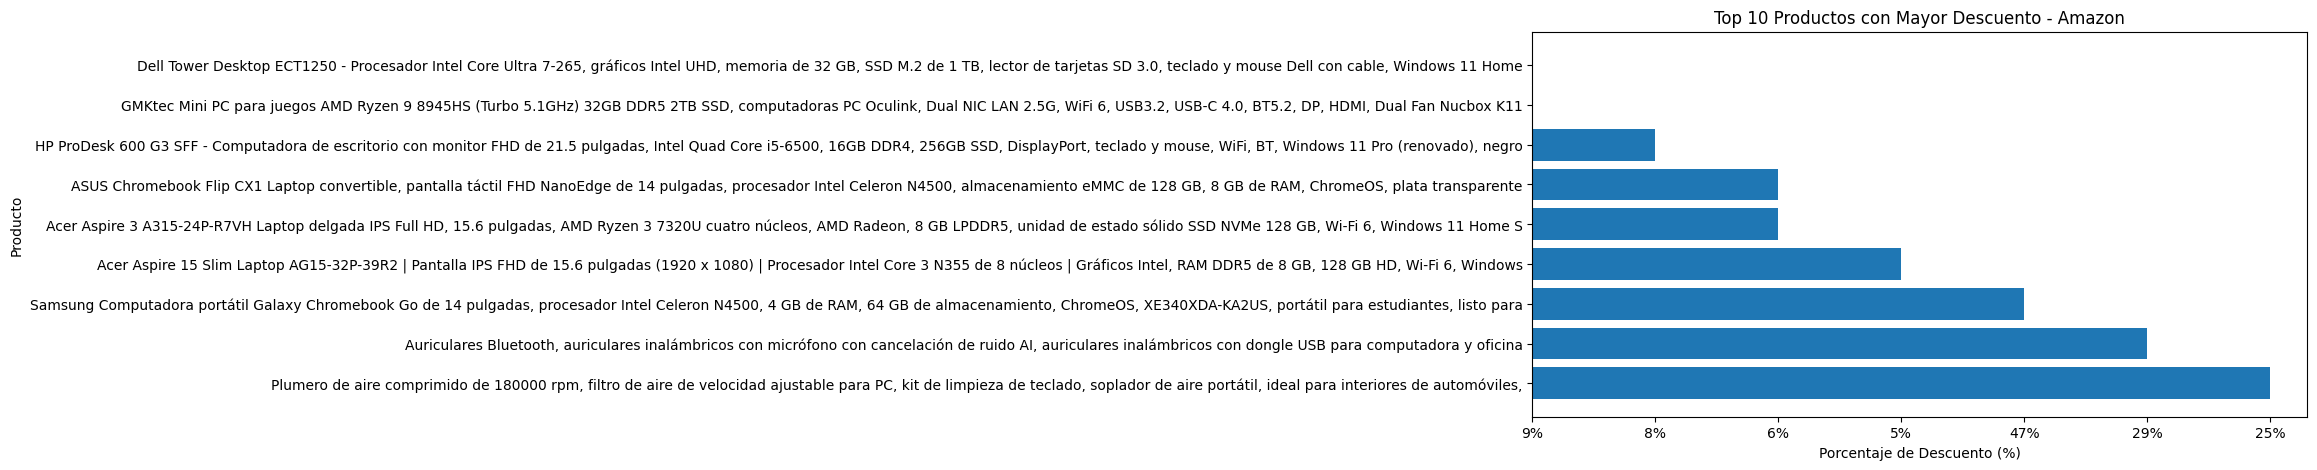

In [48]:
import matplotlib.pyplot as plt

# Ordenar y seleccionar el Top 10
top10 = df_amazon.sort_values("descuento", ascending=False).head(10)

# Gráfico de barras horizontales
plt.figure(figsize=(10,5))
plt.barh(top10["nombre"], top10["descuento"])
plt.title("Top 10 Productos con Mayor Descuento - Amazon")
plt.xlabel("Porcentaje de Descuento (%)")
plt.ylabel("Producto")
plt.gca().invert_yaxis()  # Pone el mayor primero arriba
plt.show()
